# Algorithmic Trading Model for Simple Trend-Following Strategy Using Python Take 3
### David Lowe
### January 5, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model examines a simple trend-following strategy for a stock. The model buys a stock when the price reaches the highest price for the last X number of days. The model will exit the long position when the stock price crosses below the mean of the same window size. Conversely, the model shorts a stock when the price reaches below the lowest price for the last X number of days. The model will exit the short position when the stock price crosses above the mean of the same window size.

From iteration Take1, we set up the models using one fixed window size for long trades only. The window size varied from 10 to 50 trading days at a 5-day increment.

From iteration Take2, we set up the models using one fixed window size for long trades only. The window size will vary from 10 to 50 trading days at a 5-day increment. In addition, the models took into account a volume indicator with its own window size to confirm the buy/sell signal.

In this Take3 iteration, we will set up the models using one fixed window size for both long and short trades. The window size will vary from 10 to 50 trading days at a 5-day increment.

ANALYSIS: From iteration Take1, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2019, and December 24, 2020. The trading model produced a profit of 81.49 dollars per share. The buy-and-hold approach yielded a gain of 92.60 dollars per share.

In this Take2 iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2019, and December 24, 2020. The trading model produced a profit of 82.47 dollars per share. The buy-and-hold approach yielded a gain of 92.60 dollars per share.

In this Take2 iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2019, and December 24, 2020. The trading model produced a profit of 82.47 dollars per share. The buy-and-hold approach yielded a gain of 92.60 dollars per share.

CONCLUSION: For the stock of AAPL during the modeling time frame, the trading strategy did not produce a better return than the buy-and-hold approach. We should consider modeling this stock further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

In [94]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [95]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [96]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#
# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [97]:
# # Retrieve the CPU information
# ncpu = !nproc
# print("The number of available CPUs is:", ncpu[0])

### 1.a) Load libraries and modules

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv
# import pandas_datareader.data as pdr

# Begin the timer for the script processing
startTimeScript = datetime.now()

### 1.b) Set up the controlling parameters and functions¶

In [99]:
# Specify the key modeling parameters below
STOCK_SYMBOL = 'AAPL'
INITIAL_CAPITAL = 0

# Specify the moving average parameters for the trading strategy
WINDOW_MIN = 10
WINDOW_MAX = 10
WINDOW_INCREMENT = 5

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of slow MA)
EXTRA_DAYS = WINDOW_MAX

MODEL_START_DATE = date(2019, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

MODEL_END_DATE = datetime.now().date()
# MODEL_END_DATE = date(2020, 11, 20)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 1.5)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

Starting date for the model: 2019-01-01
Ending date for the model: 2020-12-25
First date of data we need for modeling: 2018-12-17
Last date of data we need for modeling: 2020-12-25


In [100]:
# Specify the script running parameters below

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 255)

# Configure the plotting style
plt.style.use('seaborn')

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose_signals = True
verbose_models = True
verbose_graphs = False
verbose_portfolios = False
verbose_transactions = False
verbose_positions = False

In [101]:
# Set up the parent directory location for loading the dotenv files

# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up access to the dotenv file on local PC
env_path = "/Users/david/PycharmProjects/"
dotenv_path = env_path + "python_script.env"
load_dotenv(dotenv_path=dotenv_path)

True

## Task 2 - Acquire and Pre-Process Data

In [102]:
# Set up the data service provider and data acquisition parameters
data_service = 'Quandl'

# Check and see whether the API key is available
api_key = os.environ.get('QUANDL_API')
if api_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

start_date_string = data_start_date.strftime('%Y-%m-%d')
end_date_string = data_end_date.strftime('%Y-%m-%d')
api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, STOCK_SYMBOL, api_key)
response = requests.get(api_url)
resp_dict = json.loads(response.text)
stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
print(len(stock_rawdata), 'data points retrieved from the API call.')

511 data points retrieved from the API call.


In [103]:
stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
# stock_rawdata.set_index('date', inplace=True)
stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
stock_pricing = stock_rawdata.sort_index(ascending=True)
print(stock_pricing.head())
print()
print(stock_pricing.tail())

           ticker        date    open    high     low   close       volume  dividend  closeunadj lastupdated
date                                                                                                        
2018-12-17   AAPL  2018-12-17  41.362  42.087  40.682  40.985  177151688.0       0.0      163.94  2020-08-31
2018-12-18   AAPL  2018-12-18  41.345  41.883  41.097  41.517  135366072.0       0.0      166.07  2020-08-31
2018-12-19   AAPL  2018-12-19  41.500  41.862  39.773  40.222  196189188.0       0.0      160.89  2020-08-31
2018-12-20   AAPL  2018-12-20  40.100  40.528  38.825  39.208  259091840.0       0.0      156.83  2020-08-31
2018-12-21   AAPL  2018-12-21  39.215  39.540  37.407  37.682  382977536.0       0.0      150.73  2020-08-31

           ticker        date    open     high      low    close       volume  dividend  closeunadj lastupdated
date                                                                                                           
2020-12-18  

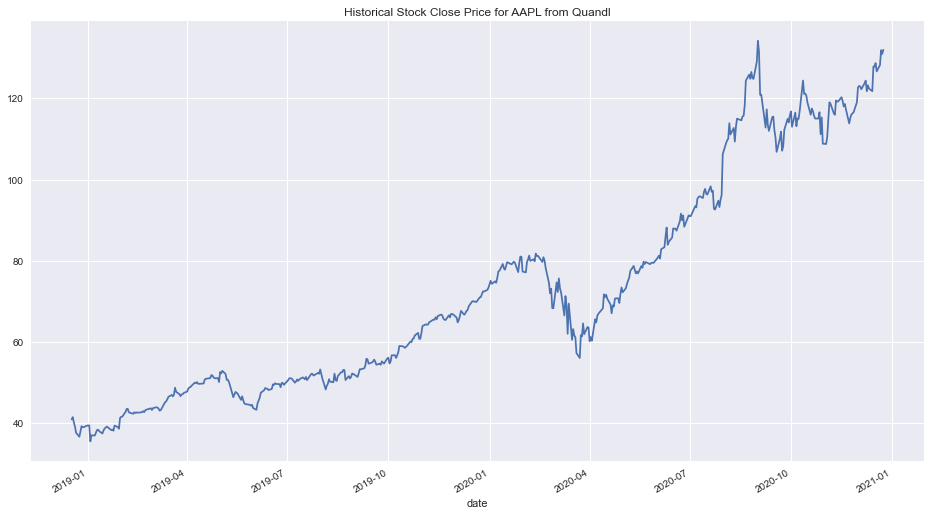

In [104]:
# Set up the standard column name for modeling
# Column names may be data-provider specific!
MODEL_TEMPLATE = stock_pricing.loc[:, ['open','close','volume']]
MODEL_TEMPLATE.rename(columns={'open': 'open_price', 'close': 'close_price', 'volume': 'trading_volume'}, inplace=True)
plot_title = 'Historical Stock Close Price for ' + STOCK_SYMBOL + ' from ' + data_service
MODEL_TEMPLATE['close_price'].plot(figsize=(16,9), title=plot_title)
plt.show()

## Task 3 - Implement and Train Models

In [105]:
# Define the function that will generate the indicators and trading signals
def populate_signals(window=WINDOW_MIN):

    trade_model = MODEL_TEMPLATE.copy()
    trade_model['window_high'] = trade_model['close_price'].shift(1).rolling(window=window).max()
    trade_model['window_low'] = trade_model['close_price'].shift(1).rolling(window=window).min()
    trade_model['window_avg'] = trade_model['close_price'].shift(1).rolling(window=window).mean()
    trade_model['buy_on_open'] = False
    trade_model['sell_on_open'] = False
    trade_model['short_on_open'] = False
    trade_model['cover_on_open'] = False
    trade_model['position_long'] = False
    trade_model['position_short'] = False
    trade_model['close_above_avg'] = False
    trade_model['close_below_avg'] = False

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]
    last_index = len(trade_model) - 1

    for k in range(len(trade_model)):
        breakout_high = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_high']
        crossover = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_avg']
        breakout_low = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_low']
        if k == 0:
            currently_hold_position = False
        else:
            currently_hold_position = trade_model.at[trade_model.index[k-1],'position_long'] or trade_model.at[trade_model.index[k-1],'position_short']

        # Check to see whether we need to execute any trade action on open
        if trade_model.at[trade_model.index[k],'buy_on_open']:
            trade_model.at[trade_model.index[k],'position_long'] = True
        elif trade_model.at[trade_model.index[k],'short_on_open']:
            trade_model.at[trade_model.index[k],'position_short'] = True
        elif trade_model.at[trade_model.index[k],'sell_on_open']:
            trade_model.at[trade_model.index[k],'position_long'] = False
        elif trade_model.at[trade_model.index[k],'cover_on_open']:
            trade_model.at[trade_model.index[k],'position_short'] = False
        else:
            # If no trade on open, check to see whether we have a breakout either way
            if (breakout_high >= 0) and (not currently_hold_position) and (k < last_index-1):
                trade_model.at[trade_model.index[k+1],'buy_on_open'] = True
            elif (breakout_low < 0) and (not currently_hold_position) and (k < last_index-1):
                trade_model.at[trade_model.index[k+1],'short_on_open'] = True
            else:
                # If no breakout, check to see whether we need to exit an existing position
                if crossover >= 0:
                    trade_model.at[trade_model.index[k],'close_above_avg'] = True
                    if currently_hold_position and (k > 0) and (k < last_index-1) and trade_model.at[trade_model.index[k-1],'close_below_avg']:
                        trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
                else:
                    trade_model.at[trade_model.index[k],'close_below_avg'] = True
                    if currently_hold_position and (k > 0) and (k < last_index-1) and trade_model.at[trade_model.index[k-1],'close_above_avg']:
                        trade_model.at[trade_model.index[k+1],'sell_on_open'] = True

            # If no action on a given day, carry over the position status
            if (k > 0) and (not trade_model.at[trade_model.index[k],'buy_on_open']) and (not trade_model.at[trade_model.index[k],'sell_on_open']) and (not trade_model.at[trade_model.index[k],'short_on_open']) and (not trade_model.at[trade_model.index[k],'cover_on_open']):
                trade_model.at[trade_model.index[k],'position_long'] = trade_model.at[trade_model.index[k-1],'position_long']
                trade_model.at[trade_model.index[k],'position_short'] = trade_model.at[trade_model.index[k-1],'position_short']

        # Exiting the position on the last day of modeling period
        if k == last_index-1:
            if trade_model.at[trade_model.index[k],'position_long']:
                trade_model.at[trade_model.index[k+1],'sell_on_open'] = True
                trade_model.at[trade_model.index[k+1],'position_long'] = False
            elif trade_model.at[trade_model.index[k],'position_short']:
                trade_model.at[trade_model.index[k+1],'cover_on_open'] = True
                trade_model.at[trade_model.index[k+1],'position_short'] = False

    if verbose_signals: print(trade_model, '\n')
    return trade_model

In [106]:
# Build the collection of trading models by iterating through the parameters
trading_model_collection = {}
serial_no = 0
for window_size in range(WINDOW_MIN, WINDOW_MAX+1, WINDOW_INCREMENT):
    serial_no += 1
    model_tag = 'Model_' + str(serial_no).zfill(3) + '_WINDOW_' + str(window_size).zfill(2)
    if verbose_signals: print('Processing model:', model_tag)
    trading_model = populate_signals(window_size)
    trading_model_collection[model_tag] = trading_model.copy()
print(len(trading_model_collection), 'trading models generated!')

Processing model: Model_001_WINDOW_10
            open_price  close_price  trading_volume  window_high  window_low  window_avg  buy_on_open  sell_on_open  short_on_open  cover_on_open  position_long  position_short  close_above_avg  close_below_avg
date                                                                                                                                                                                                              
2019-01-02      38.722       39.480     148158948.0       41.517      36.708     39.3144        False         False          False          False          False           False             True            False
2019-01-03      35.995       35.547     365248780.0       41.517      36.708     39.1639        False         False          False          False          False           False            False            False
2019-01-04      36.133       37.065     234428280.0       40.222      35.547     38.5669        False         False   

In [107]:
# List the entry/exit points for each model
def list_model_entry_exit(trade_model):
    print(trade_model[trade_model['buy_on_open'] | trade_model['sell_on_open'] | trade_model['short_on_open'] | trade_model['cover_on_open']])

In [108]:
if verbose_models:
    for model_name in trading_model_collection:
        print('List the signal changes and entry/exit points for model:', model_name)
        list_model_entry_exit(trading_model_collection[model_name])
        print()

List the signal changes and entry/exit points for model: Model_001_WINDOW_10
            open_price  close_price  trading_volume  window_high  window_low  window_avg  buy_on_open  sell_on_open  short_on_open  cover_on_open  position_long  position_short  close_above_avg  close_below_avg
date                                                                                                                                                                                                              
2019-01-04      36.133       37.065     234428280.0       40.222      35.547     38.5669        False         False           True          False          False            True            False            False
2019-01-10      38.125       38.450     143122680.0       39.480      35.547     38.1913        False         False          False           True          False           False            False            False
2019-01-18      39.375       39.205     135004092.0       38.965      36.983   

In [109]:
def draw_model_graph(trade_model, mdl_name=STOCK_SYMBOL):
    graph_data = trade_model.copy()
    title_string = 'Simple Trend-Following Trading Model for ' + mdl_name
    fig = plt.figure(figsize=(16,9))
    ylabel = STOCK_SYMBOL + ' price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data['buy_on_open']].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='b',label='Buy on Open')
    ax1.plot(graph_data.loc[graph_data['sell_on_open']].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='b',label='Sell on Open')
    ax1.plot(graph_data.loc[graph_data['short_on_open']].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='r',label='Short on Open')
    ax1.plot(graph_data.loc[graph_data['cover_on_open']].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='r',label='Cover on Open')
    plt.legend(loc='upper left')
    plt.show()

In [110]:
if verbose_graphs:
    for model_name in trading_model_collection:
        draw_model_graph(trading_model_collection[model_name], model_name)

## Task 4 - Back-test Models

In [ ]:
def generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'price_executed', 'qty_transacted', 'cost_basis', 'gain_loss', 'qty_on_hand', 'cash_on_hand', 'position_value', 'total_position', 'accum_return'])
    portfolio['trade_action'] = False
    portfolio.iloc[0]['price_executed'] = 0.00
    portfolio.iloc[0]['qty_transacted'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['qty_on_hand'] = 0
    portfolio.iloc[0]['cash_on_hand'] = INITIAL_CAPITAL
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = INITIAL_CAPITAL
    portfolio.iloc[0]['accum_return'] = portfolio.iloc[0]['total_position'] - INITIAL_CAPITAL
    quantity = 1

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        price_per_share = trade_model.at[trade_model.index[i],'open_price']
        if trade_model.at[trade_model.index[i],'buy_on_open']:
            # Code block for Buy on Open
            portfolio.iloc[i]['trade_action'] = True
            portfolio.iloc[i]['price_executed'] = price_per_share
            portfolio.iloc[i]['qty_transacted'] = quantity
            recent_cost = price_per_share * -quantity
            portfolio.iloc[i]['cost_basis'] = recent_cost
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.iloc[i]['cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_portfolios: print('BOUGHT QTY:', quantity, 'on', portfolio.index[i], 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'sell_on_open']:
            # Code block for Sell on Open
            portfolio.iloc[i]['trade_action'] = True
            portfolio.iloc[i]['price_executed'] = price_per_share
            portfolio.iloc[i]['qty_transacted'] = -quantity
            recent_cost = 0.00
            portfolio.iloc[i]['cost_basis'] = recent_cost
            portfolio.iloc[i]['gain_loss'] = (price_per_share * quantity) + portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.iloc[i]['cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + (price_per_share * quantity)
            if verbose_portfolios: print('SOLD QTY:', quantity, 'on', portfolio.index[i], 'at the price of', price_per_share)
        elif trade_model.at[trade_model.index[i],'short_on_open']:
            # Code block for Short on Open
            portfolio.iloc[i]['trade_action'] = True
            portfolio.iloc[i]['price_executed'] = price_per_share
            portfolio.iloc[i]['qty_transacted'] = -quantity
            recent_cost = price_per_share * quantity
            portfolio.iloc[i]['cost_basis'] = recent_cost
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] - quantity
            portfolio.iloc[i]['cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + recent_cost
            if verbose_portfolios: print('SHORTED QTY:', -quantity, 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif trade_model.at[trade_model.index[i],'cover_on_open']:
            # Code block for Cover on Open
            portfolio.iloc[i]['trade_action'] = True
            portfolio.iloc[i]['price_executed'] = price_per_share
            portfolio.iloc[i]['qty_transacted'] = quantity
            recent_cost = 0.00
            portfolio.iloc[i]['cost_basis'] = recent_cost
            portfolio.iloc[i]['gain_loss'] = portfolio.iloc[i-1]['cost_basis'] - (price_per_share * quantity)
            portfolio.iloc[i]['qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand'] + quantity
            portfolio.iloc[i]['cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand'] + (price_per_share * quantity)
            if verbose_portfolios: print('COVERED QTY:', quantity, 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            # Code block for no trade actions
            portfolio.iloc[i]['price_executed'] = 0.00
            portfolio.iloc[i]['qty_transacted'] = 0
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['qty_on_hand'] = portfolio.iloc[i-1]['qty_on_hand']
            portfolio.iloc[i]['cash_on_hand'] = portfolio.iloc[i-1]['cash_on_hand']
        portfolio.iloc[i]['position_value'] = trade_model.at[trade_model.index[i],'close_price'] * portfolio.iloc[i]['qty_on_hand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_on_hand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accum_return'] = portfolio.iloc[i]['total_position'] - INITIAL_CAPITAL

    if verbose_portfolios: print('\n', portfolio, '\n')
    return portfolio

In [ ]:
def calculate_positions_and_performance(trade_model):
    trade_positions = generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action']]
    if verbose_transactions: print(trade_transactions)
    if verbose_transactions:
        if trade_transactions.iloc[-1]['trade_action']:
            print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1].date(), '\n')
        else:
            print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1].date(), '\n')
    return trade_positions

In [ ]:
# Convert trading models into positions and calculate profit and loss
# Initialize a dictionary for tracking positions for all models
model_positions_colletion={}

for model_name in trading_model_collection:
    if verbose_portfolios: print('Processing the positions for model:', model_name)
    model_positions_colletion[model_name] = calculate_positions_and_performance(trading_model_collection[model_name])
print(len(model_positions_colletion), 'sets of model positions generated.')

In [ ]:
# Initialize a dataframe for storing the model's profit and loss
model_performance_summary = pd.DataFrame(columns=['Model_name','Return_value','Return_percentage'])
for model_name in model_positions_colletion:
    if verbose_positions: print('Processing positions for model:', model_name)
    if verbose_positions: print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model_positions_colletion[model_name].accum_return[-1]))
    if INITIAL_CAPITAL != 0:
        return_percentage = model_positions_colletion[model_name].accum_return[-1] / INITIAL_CAPITAL * 100
        if verbose_positions: print('Accumulated return percentage based on the initial capital investment: %.2f%%' % return_percentage)
    else:
        return_percentage = None
    if verbose_positions: print()
    model_performance_summary = model_performance_summary.append({'Model_name': model_name, 'Return_value': model_positions_colletion[model_name].accum_return[-1], 'Return_percentage': return_percentage}, ignore_index=True)
    model_performance_summary.sort_values(by=['Return_value'], inplace=True, ascending=False)

print(len(model_performance_summary), 'profit/loss summaries generated.\n')
print('The top ten model\'s performance summary:')
print(model_performance_summary.head(10))

## Task 5 - Evaluate Strategy Performance

In [ ]:
# Calculate the stock's performance for a buy-and-hold model
top_model_name = model_performance_summary.loc[0]['Model_name']
top_trading_model = trading_model_collection[top_model_name]
print('The entry point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[0]['open_price'], top_trading_model.index[0].date()))
print('The exit point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[-1]['open_price'], top_trading_model.index[-1].date()))
print('The performance of the buy-and-hold model: $%.2f' %(top_trading_model.iloc[-1]['open_price'] - top_trading_model.iloc[0]['open_price']))
print('The performance of the top trading model: $%.2f' %(model_performance_summary.iloc[0]['Return_value']))

In [ ]:
top_model_positions = model_positions_colletion[top_model_name]
print(top_model_positions[top_model_positions['trade_action'] != 0])

In [ ]:
draw_model_graph(trading_model_collection[top_model_name], top_model_name)

In [ ]:
print ('Total time for the script:',(datetime.now() - startTimeScript))